In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
audio_file = 'crowd_train/wavs/475e76f77ac1ed7cabafca740b15b32a.wav'
ipd.Audio(audio_file)

In [3]:
sample_rate, audio = wavfile.read(audio_file)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 16000Hz
Audio duration: 2.453s


C:\Users\Никита\AppData\Local\Temp\ipykernel_5116\483882377.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read(audio_file)


In [4]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

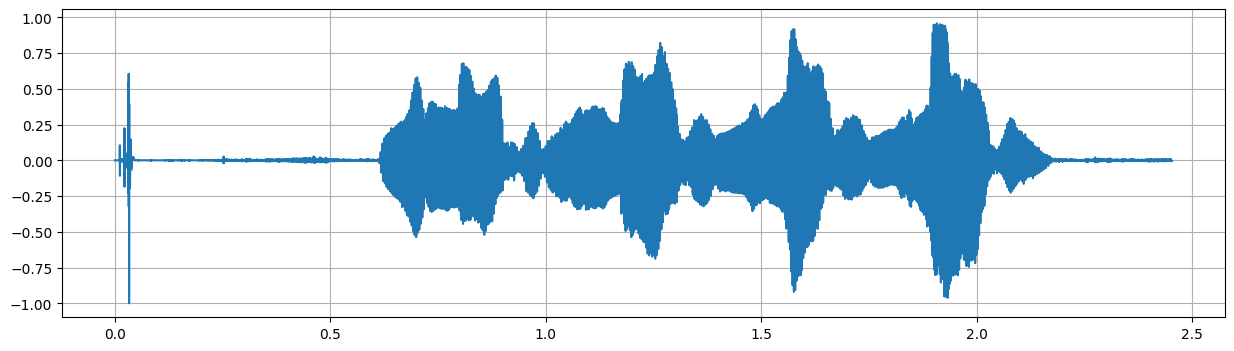

In [5]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [6]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect') # паддинг для прохождения окном
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [7]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (164, 2048)


In [8]:
def plot_audio(audio): 
    plt.figure(figsize=(15,4))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    plt.grid(True)

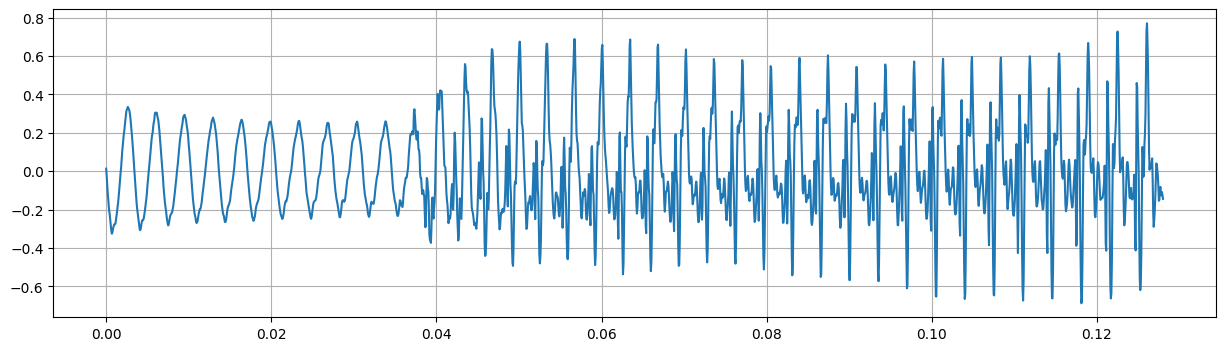

In [9]:
plot_audio(audio_framed[80])

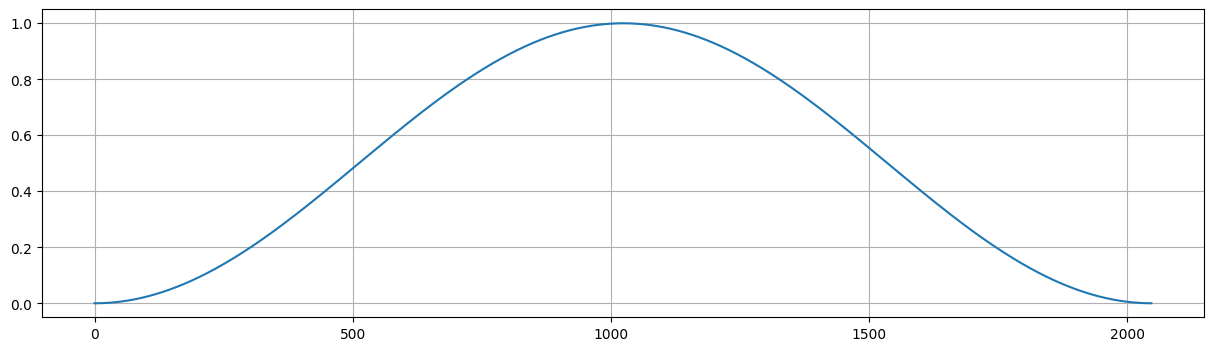

In [10]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

Применяем окно к сигналу, чтобы сделать его не переодическим, а закаонченным в условиях одного фрейма

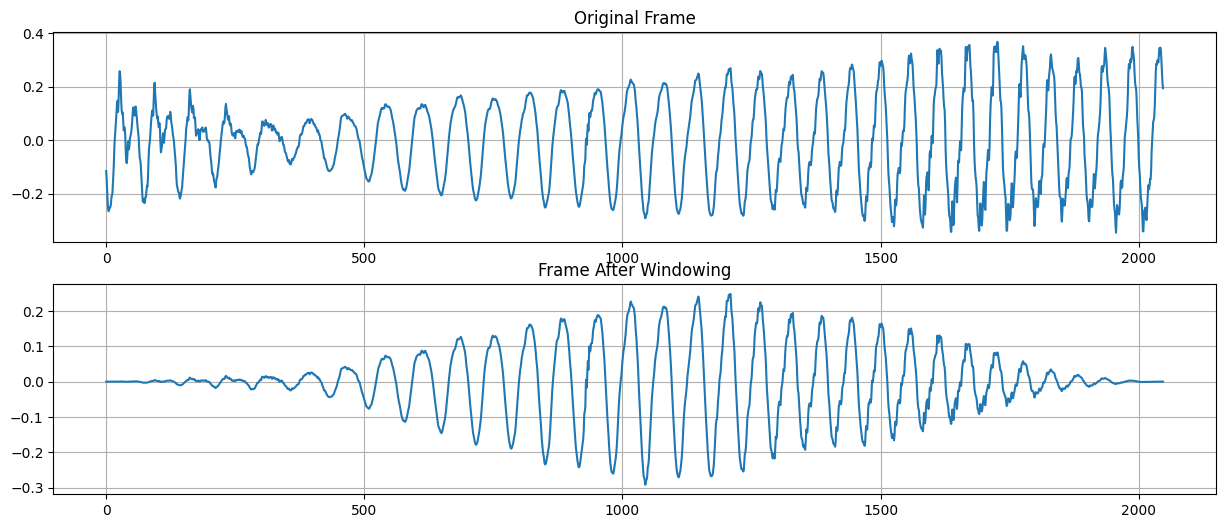

In [11]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [12]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F') #пополам, так как спектр симметричен

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [13]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(164, 1025)


In [14]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


In [15]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [16]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [17]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
filter_points, mel_freqs

MEL min: 0.0
MEL max: 2840.023046708319


(array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
        1024]),
 array([   0.        ,  180.21928115,  406.83711843,  691.7991039 ,
        1050.12629534, 1500.70701371, 2067.29249375, 2779.74887082,
        3675.63149949, 4802.16459006, 6218.73051459, 8000.        ]))

In [18]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1))) # половина fft достаточна из-за симметричности
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n]) # возрастающий треугольник
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1]) # убывающий треугольник
    
    return filters

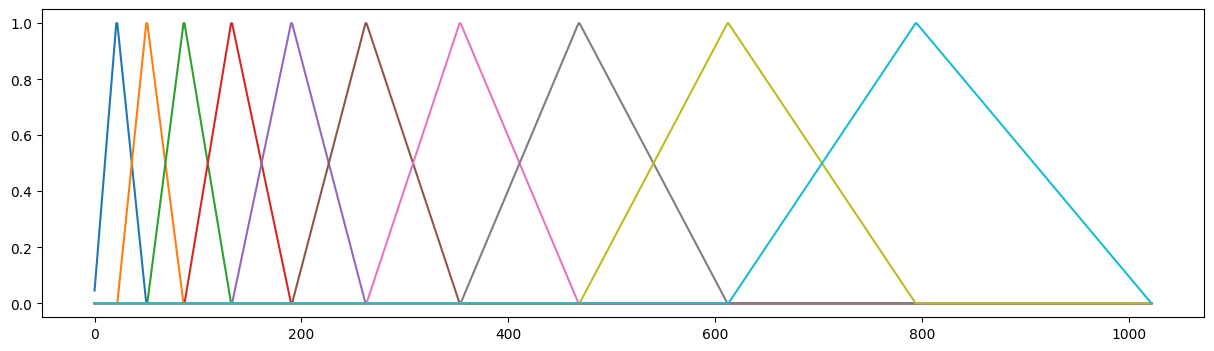

In [19]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n][1:-1])

In [20]:
# нормализация MEL фильтров
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

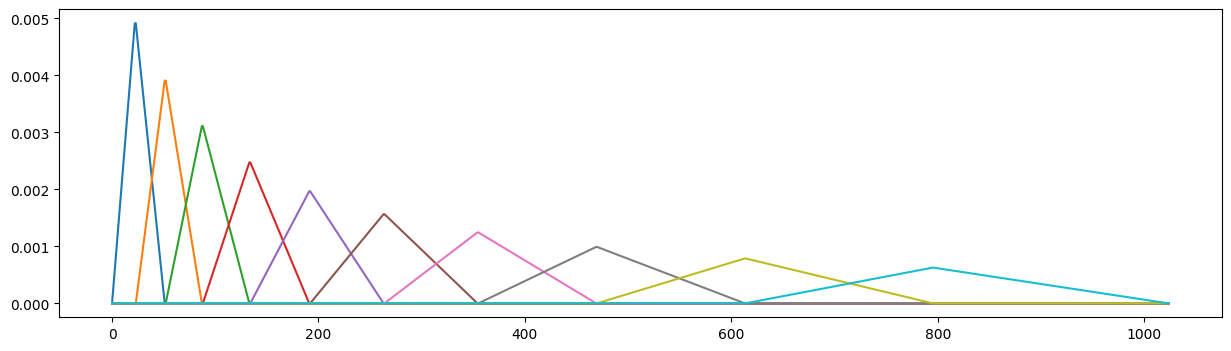

In [21]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Перевод в децибелы
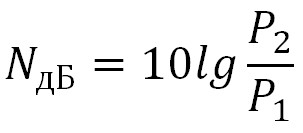

In [22]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 164)

https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%BD%D0%BE%D0%B5_%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5
DCT 3

In [23]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [24]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 164)

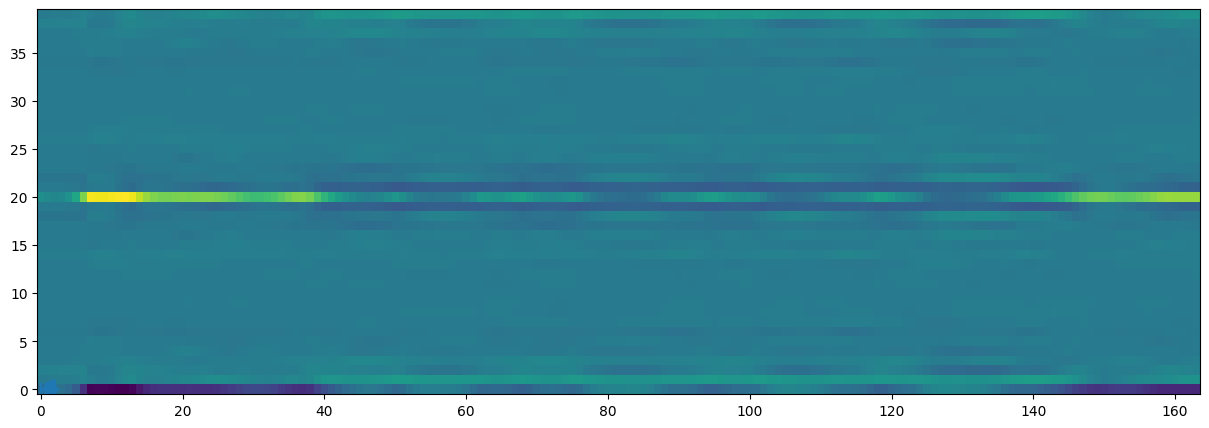

In [25]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [54]:
import librosa

def mfccs_from_file(file_path, maxlen=None):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')

        if len(audio) == 0:
            raise ValueError(f"Input signal length is too small in file: {file_path}")

        if sr != 22050:
            audio = librosa.resample(audio, sr, 22050, res_type='kaiser_fast')

        mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=20)

        maxlen = maxlen if maxlen else 256
        if mfccs.shape[1] > maxlen:
            mfccs = mfccs[:, :maxlen]
        elif mfccs.shape[1] < maxlen:
            mfccs = np.pad(mfccs, ((0, 0), (0, maxlen - mfccs.shape[1])), mode='constant')

        return mfccs
    except Exception as e:
        print(e)

In [60]:
audio_file = 'crowd_train/wavs/475e76f77ac1ed7cabafca740b15b32a.wav'
ipd.Audio(audio_file)

In [61]:
len(mfccs_from_file(audio_file))

20

In [62]:
audio_file = 'crowd_train/wavs/d86ed39def3c397923442c8cc4a081b7.wav'
ipd.Audio(audio_file)

In [63]:
len(mfccs_from_file(audio_file))

20